In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from typing import Optional, Iterable, Tuple
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
import scipy.stats as ss
from seqloops.config import data_dir
from seqloops.data_loaders import get_dna2vec

# Exploration of DNA sequence at chromatin loops

In this notebook, we explore the relationship between sequence features and chromatin loops.
We use the dna2vec embedding to encode sequences.


In [2]:

def load_anchors(path: str, score_val: Optional[int]=None) -> pd.DataFrame:
    """
    Parse a fasta file with space-separated features in header into a dataframe.
    If score is None, it is read from the fasta headers, otherwise the input value is used.
    """
    seqs = []
    # Store records into a list of rows
    for rec in SeqIO.parse(path, 'fasta'):
        if score_val is None:
            _, chrom, start, end, score = rec.description.split(' ')
        else:
            _, chrom, start, end = rec.description.split(' ')
            score = score_val
        anchor = [chrom, start, end, score, str(rec.seq)]
        seqs.append(anchor)
    # Make dataframe from rows and remove duplicate sequences
    anchors = pd.DataFrame(seqs)
    anchors.columns = ['chrom', 'start', 'end', 'score', 'seq']
    anchors['score'] = anchors['score'].astype(float)
    anchors = anchors.sort_values('score').groupby(['chrom', 'start', 'end']).tail(1)
    anchors = anchors.loc[anchors['seq'].apply(len) > 0, :]
    return anchors

The input loop dataset contains chromatin loop coordinates, and their sequence.
In order to convert these sequence into numeric vectors, we'll use the dna2vec embedding.

In [3]:
neg = load_anchors(str(data_dir / 'input/hic/negative_loop_seq.fasta'), score_val=0)
pos = load_anchors(str(data_dir / 'input/hic/positive_loop_seq.fasta'), score_val=1)
loops = pd.concat([neg, pos]).reset_index(drop=True)
dna2vec = get_dna2vec()
loops.head()

,chrom,start,end,score,seq
0,chr1,3600,3800,0.0,AACAACTTTCCGATCATTGGTGCCCGTATCTGATGTTTTTTTAGTA...
1,chr12,5500,5700,0.0,AAAAAAATTCCTTGACGCTAGATCGTTGGACTAAAATCTGCGTCAC...
2,chr12,16800,17000,0.0,ATTGTAGATTTCTCCACTGTTTGGGTAAACTAGCAGAGGCATGCCA...
3,chr12,51900,52100,0.0,CATCATCAGAAGATTCGCATTATGGTAATGCTAAGAAGGTAACATG...
4,chr12,52100,52300,0.0,AACCTAACCAACTAAATATGAAAATACTGACCCATCGTCTTAAGTA...


In [4]:
# Some feature engineering

def get_vector(seq: str, k_values: Iterable[int]=range(3, 9)) -> np.ndarray:
    """
    Compute the average of embedding vectors for the sequence.
    If multiple k values are used, average vectors are concatenated
    """
    emb = []
    for k in k_values:
        # List of embedding vectors from each kmer
        vectors = [dna2vec[seq[i: i+k]] for i in range(len(seq)-k+1)]
        # Compute average vector for the sequence
        emb.append(np.array(vectors).mean(axis=1))
    # Vector concatenation
    emb = np.hstack(emb)
    return emb 

def get_onehot(seq: str) -> np.ndarray:
    """ Returns the flattened onehot encoding of input DNA sequence"""
    base2idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    onehot = np.zeros((4, len(seq)), dtype=float)
    for i, b in enumerate(seq):
        onehot[base2idx[b], i] = 1.0
    return onehot.flatten()

def get_gc(seq: str) -> float:
    """Compute GC content of input sequence"""
    return (seq.count('G') + seq.count('C')) / len(seq)

def get_entro(seq: str) -> float:
    """Compute shannon entropy of input sequence"""
    entro = 0
    for base in ['A', 'C', 'T', 'G']:
        prob = seq.count(base) / len(seq)
        if prob:
            entro += prob * np.log2(prob)
    return -entro / 2.0


In [5]:
loops['emb'] = loops['seq'].apply(get_vector)
loops['onehot'] = loops['seq'].apply(get_onehot)
loops['gc'] = loops['seq'].apply(get_gc)
loops['entro'] = loops['seq'].apply(get_entro)
features = loops[['gc', 'entro']]

General sequence statistics are vaguely different between loops and non-loops, but this is mostly a consequence of loops being often localized between convergent genes, whereas the non-loop set is randomly sampled in the genome.

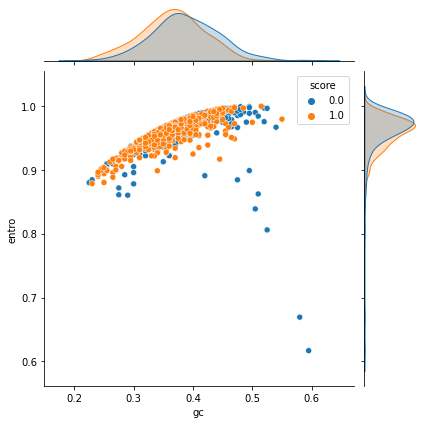

In [8]:
%matplotlib inline
# visualize features
sns.jointplot(data=loops, x='gc', y='entro', hue='score')

In [9]:
ss.mannwhitneyu(
    loops.loc[loops['score'] == 1.0, 'entro'],
    loops.loc[loops['score'] == 0.0, 'entro']
)

MannwhitneyuResult(statistic=56360.0, pvalue=4.8630754019897024e-08)

To reduce the number of dimensions, we try to use PCA on the embedding, we'll use the resulting principal components as features later on.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'PC1')

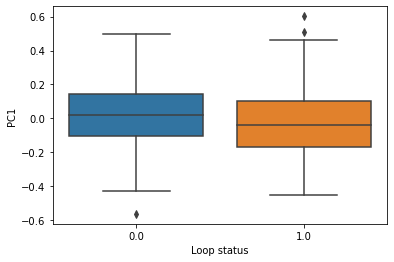

In [11]:
%matplotlib inline

pca = PCA()
onehot = np.vstack(loops.onehot.tolist())
cat_emb = np.vstack(loops.emb.tolist())
pcs = pca.fit_transform(cat_emb)
sns.boxplot(loops['score'], pcs[:, 0] )
plt.xlabel("Loop status")
plt.ylabel("PC1")

We attempt to predict the loop/non-loop status using a random forest based on the following features:

* GC content
* Information entropy of the sequence
* first 5 PCs of the PCA on dna2vec

In [12]:

X = np.hstack([pcs[:, :6], features])
y = loops['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30)
regr = RandomForestClassifier(max_depth=10)
#regr = LinearRegression()
regr.fit(X_train, y_train)
pred_test = regr.predict(X_test)


In [13]:
(pred_test == y_test).sum() / y_test.shape[0]

0.5589519650655022

In [14]:
ss.spearmanr(y_test, pred_test)

SpearmanrResult(correlation=0.17390980784910423, pvalue=0.008352952174256184)

In [25]:
ss.mannwhitneyu(
    pred_test[y_test > 0.2],
    pred_test[y_test < 0.2]
)

MannwhitneyuResult(statistic=5831.5, pvalue=0.046223429060008064)

In [26]:
print(f"median prediction for non-loops: {np.median(pred_test[y_test < 0.2])}")
print(f"median prediction for loops: {np.median(pred_test[y_test > 0.2])}")

median prediction for non-loops: 1.0
median prediction for loops: 1.0


Here we attempt to classify them using a shallow neural network instead.

In [21]:
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import (
    Input,
    Dense
)
def get_model(dim):
    inp = Input(shape=(dim, ))
    x = Dense(5, activation='relu')(inp)
    x = Dense(5, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=out)
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss='mse', metrics=['mse'])
    return model
    

In [22]:
X = np.hstack([pcs[:, :5], features.values])
y = loops['score']

cv_mse = []
cv_acc = []
kf = KFold(n_splits=5, shuffle=True)
for train_idx, val_idx in kf.split(X):
    kf_X_train, kf_X_val = X[train_idx], X[val_idx]
    kf_y_train, kf_y_val = y[train_idx], y[val_idx]
    model = get_model(X.shape[1])
    model.fit(kf_X_train, kf_y_train, epochs=10, batch_size=32, verbose=0)
    pred = model.predict(kf_X_val).flatten()
    truth = kf_y_val.values
    cv_mse.append(np.mean((pred - truth)**2))
    pseudo_acc = ((pred > 0.2) & (truth > 0.2)).sum() / len(val_idx)
    cv_acc.append(pseudo_acc)
    
    
    

In [23]:
cv_acc

[0.4444444444444444,
 0.5032679738562091,
 0.48026315789473684,
 0.5263157894736842,
 0.5921052631578947]